In [2]:
!pip install tqdm
!pip install --upgrade torch torchvision
!pip install matplotlib numpy

In [3]:
# Running these commands first to fix installation issues
!pip install tqdm
!pip install --upgrade torch torchvision
!pip install matplotlib numpy

#image classification code
import torch
import torch.nn as nn
import torch.optim as optim
# Trying to import with a fallback for tqdm
try:
    import torchvision
except ImportError as e:
    # Direct install of tqdm if that's the issue
    !pip install tqdm
    # Try again
    import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time
from torch.utils.data import DataLoader

In [4]:

# Set random seed for reproducibility
torch.manual_seed(42)

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define transformations
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

Using device: cpu


In [5]:

# Load CIFAR-10 dataset safely
print("Downloading and preparing CIFAR-10 dataset...")
try:
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                       download=True, transform=transform_train)
    trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=0)  # Use 0 workers to avoid issues

    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                      download=True, transform=transform_test)
    testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=0)  # Use 0 workers
    print("Dataset loaded successfully!")
except Exception as e:
    print(f"Error loading dataset: {e}")
    # Try an alternative approach if needed
    print("Trying alternative approach...")
    !pip install --upgrade torchvision
    import torchvision
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                       download=True, transform=transform_train)
    trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=0)  # Reduced batch size

    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                      download=True, transform=transform_test)
    testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=0)
    print("Dataset loaded with alternative settings!")

100%|██████████| 170M/170M [00:03<00:00, 47.8MB/s]


Dataset loaded successfully!


In [6]:


# Define classes
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

# Define a simpler CNN model to ensure compatibility
class SimpleConvNet(nn.Module):
    def __init__(self):
        super(SimpleConvNet, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)

        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)

        # Dropout
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # Layer 1
        x = self.pool(torch.relu(self.conv1(x)))
        # Layer 2
        x = self.pool(torch.relu(self.conv2(x)))

        # Flatten
        x = x.view(-1, 64 * 8 * 8)

        # Fully connected layers
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [7]:
# Initialize model
model = SimpleConvNet().to(device)
print("Model created")

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, epochs=5):
    model.train()
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    start_time = time.time()

    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for i, data in enumerate(trainloader, 0):
            # Get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Calculate statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Print statistics every 100 mini-batches
            if i % 100 == 99:
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f} acc: {100 * correct / total:.2f}%')
                running_loss = 0.0

        # Calculate epoch statistics (training)
        train_loss, train_acc = evaluate_model(model, trainloader)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Calculate epoch statistics (validation)
        val_loss, val_acc = evaluate_model(model, testloader)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print('-' * 50)

    elapsed_time = time.time() - start_time
    print(f'Training completed in {elapsed_time:.2f} seconds')

    return train_losses, train_accuracies, val_losses, val_accuracies

Model created


In [8]:

# Evaluation function
def evaluate_model(model, dataloader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    model.train()
    return running_loss / len(dataloader), 100 * correct / total


In [13]:
# Function to show images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Function to visualize model predictions
def visualize_predictions(model, dataloader, classes):
    # Get a batch of test data
    dataiter = iter(dataloader)
    images, labels = next(dataiter)

    # Print true labels
    print('True labels:', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

    # Show images
    imshow(torchvision.utils.make_grid(images[:4]))

    # Make predictions
    model.eval()
    images = images.to(device)
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    # Print predicted labels
    print('Predicted:', ' '.join('%5s' % classes[predicted[j].item()] for j in range(4)))

In [14]:
 # Function to plot training curves
def plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [15]:
# Plot confusion matrix
def plot_confusion_matrix(model, dataloader, classes):
    # Initialize confusion matrix
    conf_matrix = torch.zeros(len(classes), len(classes))

    # Evaluate model on test data
    model.eval()
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            # Update confusion matrix
            for i in range(len(labels)):
                conf_matrix[labels[i], predicted[i]] += 1

    # Normalize confusion matrix
    conf_matrix = conf_matrix / conf_matrix.sum(1, keepdim=True)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = conf_matrix.max() / 2.
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, format(conf_matrix[i, j], fmt),
                    horizontalalignment="center",
                    color="white" if conf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Starting training...
[1,   100] loss: 1.902 acc: 29.53%
[1,   200] loss: 1.603 acc: 35.51%
[1,   300] loss: 1.489 acc: 38.88%
Epoch 1/5:
Train Loss: 1.3743, Train Acc: 50.17%
Val Loss: 1.2988, Val Acc: 53.09%
--------------------------------------------------
[2,   100] loss: 1.366 acc: 50.52%
[2,   200] loss: 1.309 acc: 51.52%
[2,   300] loss: 1.258 acc: 52.50%
Epoch 2/5:
Train Loss: 1.2350, Train Acc: 55.03%
Val Loss: 1.1274, Val Acc: 59.35%
--------------------------------------------------
[3,   100] loss: 1.174 acc: 57.70%
[3,   200] loss: 1.150 acc: 58.07%
[3,   300] loss: 1.127 acc: 58.72%
Epoch 3/5:
Train Loss: 1.0650, Train Acc: 61.54%
Val Loss: 0.9947, Val Acc: 63.51%
--------------------------------------------------
[4,   100] loss: 1.069 acc: 61.65%
[4,   200] loss: 1.041 acc: 62.25%
[4,   300] loss: 1.045 acc: 62.40%
Epoch 4/5:
Train Loss: 0.9632, Train Acc: 65.72%
Val Loss: 0.9084, Val Acc: 67.74%
--------------------------------------------------
[5,   100] loss: 0.989 

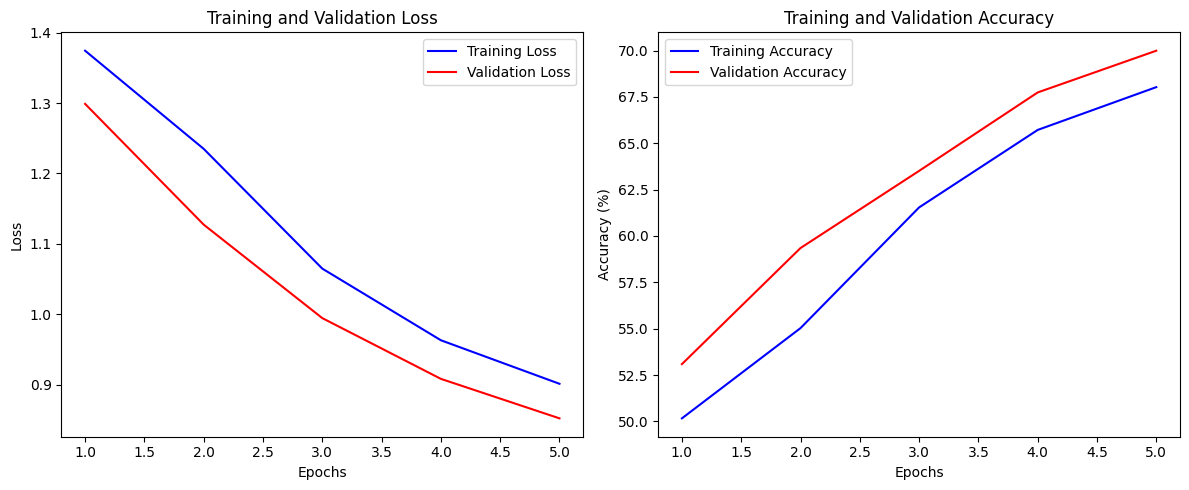

True labels:   cat  ship  ship plane


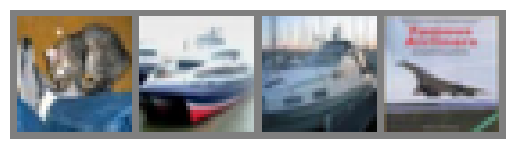

Predicted:   dog  ship  ship  ship


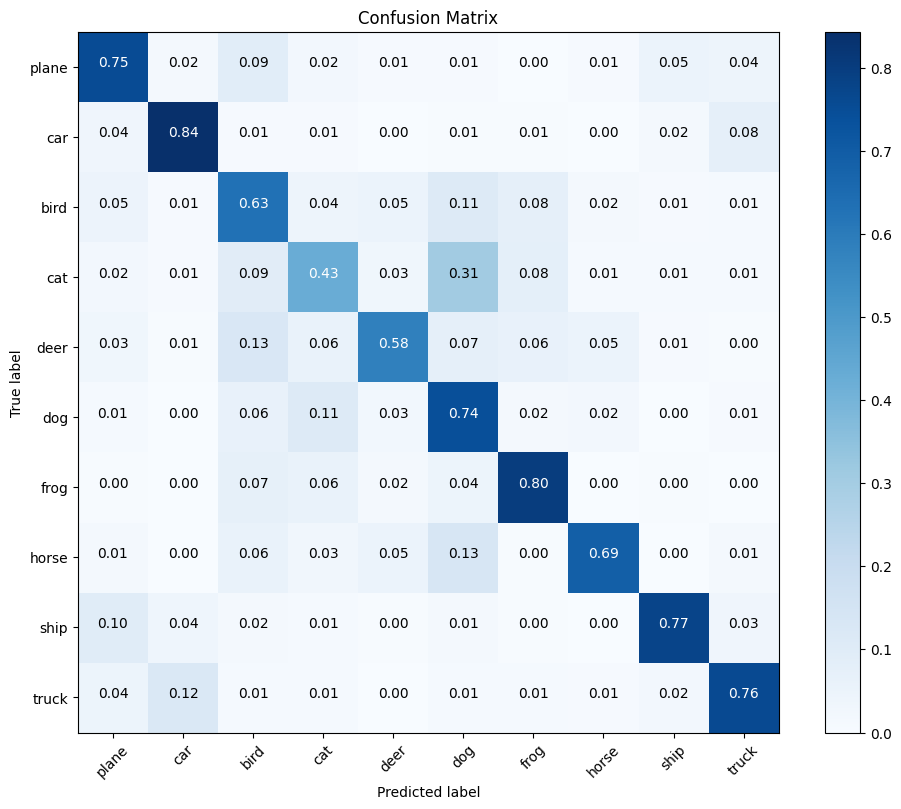

In [16]:
# Main execution - Put this in a separate cell to run after the functions are defined
print("Starting training...")
# Train for 5 epochs
train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, epochs=5)

# Save the model
torch.save(model.state_dict(), 'cifar10_model.pth')
print("Model saved to cifar10_model.pth")

# Evaluate on test set
test_loss, test_acc = evaluate_model(model, testloader)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%')

# Visualize training curves
plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies)

# Visualize sample predictions
visualize_predictions(model, testloader, classes)

# Plot confusion matrix
plot_confusion_matrix(model, testloader, classes)